<a href="https://colab.research.google.com/github/fener95/GEE-bugisu-project/blob/main/Fig3_BugisuProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference study for rusle computation (with flow accumulation) :
[Study reference](https://www.tandfonline.com/doi/full/10.1080/10095020.2014.889271#d1e548)

# SETUP

In [1]:
import ee
# Trigger the authentication flow.
ee.Authenticate(auth_mode= 'notebook',  #force =True,
                #scopes='https://www.googleapis.com/auth/earthengine'
                )
ee.Initialize(project='takehome-exam-bugisu-project')
import geemap

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=OBjK5ghl3Etebxe8xtsVTd2feFAGwcl7gd7CqSPXr-k&tc=YbdZW1--3s5DPKZ4ogVD2U7xVioV3b-nreil5bDBCS8&cc=KvglywNAGlSLAWNVRbt2l1g5DipLQr7Cj5mGUKujrBI

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AcvDMrDXdIlG6QvCD0Y6jjd5_lX20bOlWAGc_ukPJDQry5S0rYmetV1_HVo

Successfully saved authorization token.


In [ ]:
#if requested, click on the secre-key in the left panel, then insert as name: EE_PROJECT_ID, value: takehome-exam-bugisu-project
#then, run this
"""
from google.colab import userdata
userdata.get('EE_PROJECT_ID')
"""

In [2]:
Map = geemap.Map(center=[1.1, 34.2], zoom=9)

# set Area Of Interest
from my asset (should work, if it does not: use the GAUL dataset and filter for ADM1_NAME: sironko, which is the only district used in this analysis)

In [24]:
# my asset of the whole region
region = ee.FeatureCollection('projects/takehome-exam-bugisu-project/assets/bugisu_subRegion')
# filter for only the Sironko district which is the aoi for our analysis of RUSLE
geometry = region.filter(ee.Filter.eq('ADM1_NAME', 'Sironko')).geometry()

#RUSLE

script is divded by the 5 terms of RUSLE = erosivity x erodibility x Slope_Lenght (with Flow accumulation) x Cover factor x Practices applied on fields

## Precipitation from CHIRPS and water erosivity factor R

In [25]:
# Define the CHIRPS dataset
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")\
    .filter(ee.Filter.date('2022-01-01', '2022-12-31'))\
    .select('precipitation');

#sum of daily to year
# annual precipitation
precipitation = chirps.sum().rename('prep').clip(geometry)

prec_vis = {
    'min': 1000.0,
    'max': 2000.0,
    'palette': ['blue', 'purple', 'cyan', 'green', 'yellow', 'red']
};

#Map.addLayer(precipitation, prec_vis, '2022 Precipitation',0);

### interpolating using IDW

In [26]:
samples = precipitation.addBands(ee.Image.pixelLonLat())\
    .sample(**{
        'region': geometry,
        'scale': 5566,
        'numPixels': 3000,
        'seed': 0,
        'projection': 'EPSG:4326',
        'geometries': True
    });
#Combined reducer for IDW
combinedReducer = ee.Reducer.mean().combine(**{
    'reducer2': ee.Reducer.stdDev(),
    'sharedInputs': True
});
stats = samples.reduceColumns(**{
    'reducer': combinedReducer,
    'selectors': ['prep']
});

# interpolation
interpolated = samples.inverseDistance(**{
    'range':1e6,
    'propertyName':'prep',
    'mean':stats.get('mean'),
    'stdDev':stats.get('stdDev'),
    'gamma':0.3
}).clip(geometry);

#resample to 90m
def resample90(image):
    resampled = image.reproject(**{
        'crs': 'EPSG:4326',
        'scale': 90
    })
    return resampled

precip_90m = resample90(interpolated).clip(geometry)

### Monthly precipitation

In [27]:
def filter_month_precipitation(chirps, year, month):
    # Filter the CHIRPS collection to the desired month
    chirps_month = chirps.filter(ee.Filter.date(f"{year}-{month:02d}-01", f"{year}-{month:02d}-{get_last_day_of_month(year, month)}"))

    # Sum the daily precipitation to get the monthly total
    prec_month = chirps_month.sum().rename("prep")

    return prec_month
#----- this method below accounting for the differences in n of days in calendar and last day of month(28,29,30,31) is made by ChatGPT
def get_last_day_of_month(year, month):
    if month in [1, 3, 5, 7, 8, 10, 12]:
        return 31
    elif month == 2:
        if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
            return 29
        else:
            return 28
    else:
        return 30
#---end of chatgpt method for month day numerosity (specially for february last day)

# monthly precipitation
jan = filter_month_precipitation(chirps, 2022, 1)
feb = filter_month_precipitation(chirps, 2022, 2)
march = filter_month_precipitation(chirps, 2022, 3)
april = filter_month_precipitation(chirps, 2022, 4)
may = filter_month_precipitation(chirps, 2022, 5)
june = filter_month_precipitation(chirps, 2022, 6)
july = filter_month_precipitation(chirps, 2022, 7)
august = filter_month_precipitation(chirps, 2022, 8)
september = filter_month_precipitation(chirps, 2022, 9)
october = filter_month_precipitation(chirps, 2022, 10)
november = filter_month_precipitation(chirps, 2022, 11)
december = filter_month_precipitation(chirps, 2022, 12)

# interpolation

def process_month(prec_month, geometry):
    # Sample the monthly precipitation image
    samples = prec_month.addBands(ee.Image.pixelLonLat()) \
        .sample(**{
            'region': geometry,
            'scale': 5566,
            'numPixels': 3000,
            'seed': 0,
            'projection': 'EPSG:4326',
            'geometries': True
        })

    # Combined reducer for IDW
    combinedReducer = ee.Reducer.mean().combine(**{
        'reducer2': ee.Reducer.stdDev(),
        'sharedInputs': True
    })

    # Calculate the mean and std dev of the sampled data
    stats = samples.reduceColumns(**{
        'reducer': combinedReducer,
        'selectors': ['prep']
    })

    # Interpolate the monthly precipitation image
    interpolated = samples.inverseDistance(**{
        'range': 1e6,
        'propertyName': 'prep',
        'mean': stats.get('mean'),
        'stdDev': stats.get('stdDev'),
        'gamma': 0.3
    }).clip(geometry)

    # Resample the monthly precipitation image to 90 meters
    precip_90m = resample90(interpolated)

    return precip_90m


### Erosivity computation
(the same equation used at the link of this study:

[Study reference](https://www.tandfonline.com/doi/full/10.1080/10095020.2014.889271#d1e548)

for the manafwa catchment)

In [28]:
# the twelve monthly total rain of 2022 which will be the Pi in the formula of Erosivity
prepJan_90m = process_month(jan, geometry)
prepFeb_90m = process_month(feb, geometry)
prepMarch_90m = process_month(march, geometry)
prepApril_90m = process_month(april, geometry)
prepMay_90m = process_month(may, geometry)
prepJune_90m = process_month(june, geometry)
prepJuly_90m = process_month(july, geometry)
prepAugust_90m = process_month(august, geometry)
prepSeptember_90m = process_month(september, geometry)
prepOctober_90m = process_month(october, geometry)
prepNovember_90m = process_month(november, geometry)
prepDecember_90m = process_month(december, geometry)
# monthly ^2 / annual ratio
def compute_monthly_to_annual_ratio(monthly_image, annual_precip_image):
    # Extract the 'prep' band from each image
    monthly_precip = monthly_image.select('prep')
    annual_precip = annual_precip_image.select('prep')

    # Compute monthly precipitation squared
    monthly_precip_squared = monthly_precip.pow(2)

    # Compute the ratio of monthly precipitation squared to annual precipitation
    ratio_image = monthly_precip_squared.divide(annual_precip)

    return ratio_image
# ratio in the formula of erosivty (squared monthly rainfall divided the annual  rainfall)
jan_ratio = compute_monthly_to_annual_ratio(prepJan_90m,precip_90m )
feb_ratio = compute_monthly_to_annual_ratio(prepFeb_90m,precip_90m )
march_ratio = compute_monthly_to_annual_ratio(prepMarch_90m, precip_90m)
april_ratio = compute_monthly_to_annual_ratio(prepApril_90m, precip_90m)
may_ratio = compute_monthly_to_annual_ratio(prepMay_90m, precip_90m)
june_ratio = compute_monthly_to_annual_ratio(prepJune_90m, precip_90m)
july_ratio = compute_monthly_to_annual_ratio(prepJuly_90m, precip_90m)
august_ratio = compute_monthly_to_annual_ratio(prepAugust_90m, precip_90m)
september_ratio = compute_monthly_to_annual_ratio(prepSeptember_90m, precip_90m)
october_ratio = compute_monthly_to_annual_ratio(prepOctober_90m, precip_90m)
november_ratio = compute_monthly_to_annual_ratio(prepNovember_90m, precip_90m)
december_ratio = compute_monthly_to_annual_ratio(prepDecember_90m, precip_90m)

In [29]:
# Define the function to compute the erosivity image
def compute_erosivity_image(ratio_image):
    # Compute the erosivity image using the provided formula
    erosivity_image = ratio_image.expression(
        '1.735 * 10 ** (1.5 * log10(ratio) - 0.08188)', {
            'ratio': ratio_image
        })
    return erosivity_image

# Apply the erosivity formula to each ratio image
jan_erosivity = compute_erosivity_image(jan_ratio)
feb_erosivity = compute_erosivity_image(feb_ratio)
march_erosivity = compute_erosivity_image(march_ratio)
april_erosivity = compute_erosivity_image(april_ratio)
may_erosivity = compute_erosivity_image(may_ratio)
june_erosivity = compute_erosivity_image(june_ratio)
july_erosivity = compute_erosivity_image(july_ratio)
august_erosivity = compute_erosivity_image(august_ratio)
september_erosivity = compute_erosivity_image(september_ratio)
october_erosivity = compute_erosivity_image(october_ratio)
november_erosivity = compute_erosivity_image(november_ratio)
december_erosivity = compute_erosivity_image(december_ratio)

# Create an ImageCollection from the erosivity images
erosivity_collection = ee.ImageCollection([
    jan_erosivity, feb_erosivity, march_erosivity, april_erosivity,
    may_erosivity, june_erosivity, july_erosivity, august_erosivity,
    september_erosivity, october_erosivity, november_erosivity, december_erosivity
])

# Reduce the ImageCollection by summing to get the final erosivity image
final_erosivity_image = erosivity_collection.select('constant').sum().reproject(precip_90m.projection())

# Optionally, you can visualize or export the final image
#Map.addLayer(final_erosivity_image, {'min': 800, 'max':2000}, 'Erosivity Index',0)

# Erodibility

In [30]:
soil = ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02")

#soil
soil_clipped = \
soil \
.select('b0') \
.clip(geometry)

soil_clipped = soil.clip(geometry)

soil_k = soil_clipped.select('b0').rename('soil')
""""
Map.addLayer(soil_k, {'min': 1.0,
    'max': 12.0,
    'palette': [
    'd5c36b','b96947','9d3706','ae868f','f86714','46d143',
    '368f20','3e5a14','ffd557','fff72e','ff5a9d','ff005b',
]}, 'soil', False)
"""

'"\nMap.addLayer(soil_k, {\'min\': 1.0,\n    \'max\': 12.0,\n    \'palette\': [\n    \'d5c36b\',\'b96947\',\'9d3706\',\'ae868f\',\'f86714\',\'46d143\',\n    \'368f20\',\'3e5a14\',\'ffd557\',\'fff72e\',\'ff5a9d\',\'ff005b\',\n]}, \'soil\', False)\n'

In [31]:
samples_soils = soil_k.addBands(ee.Image.pixelLonLat())\
    .sample(**{
        'region': geometry,
        'scale': 232,
        'numPixels': 3000,
        'seed': 0,
        'projection': 'EPSG:4326',
        'geometries': True
    });
#Combined reducer for IDW
combinedReducerSoil = ee.Reducer.mean().combine(**{
    'reducer2': ee.Reducer.stdDev(),
    'sharedInputs': True
});
statsSoil = samples_soils.reduceColumns(**{
    'reducer': combinedReducerSoil,
    'selectors': ['b0']
});

# interpolation
interpolatedSoil = samples_soils.inverseDistance(**{
    'range':1e6,
    'propertyName':'b0',
    'mean':statsSoil.get('mean'),
    'stdDev':statsSoil.get('stdDev'),
    'gamma':0.3
}).clip(geometry);

soil_k90 = resample90(interpolatedSoil).clip(geometry)

In [32]:
K = soil_k.expression(
"(b('soil') > 11) ? 0.0053" + \
": (b('soil') > 10) ? 0.0170" + \
": (b('soil') > 9) ? 0.045"  + \
": (b('soil') > 8) ? 0.050"  + \
": (b('soil') > 7) ? 0.0499" + \
": (b('soil') > 6) ? 0.0394" + \
": (b('soil') > 5) ? 0.0264" + \
": (b('soil') > 4) ? 0.0423" + \
": (b('soil') > 3) ? 0.0394" + \
": (b('soil') > 2) ? 0.036"  + \
": (b('soil') > 1) ? 0.0341" + \
": (b('soil') > 0) ? 0.0288" + \
": 0") \
.rename('K').clip(geometry)

K90m = resample90(K).clip(geometry)
"""
Map.addLayer(K90m,
{'min':0,
    'max': 0.06,
'palette': ['3a210f','cb7a21','F18555','FCD163','760403']},
'K Factor map',
False)
"""

"\nMap.addLayer(K90m,\n{'min':0,\n    'max': 0.06,\n'palette': ['3a210f','cb7a21','F18555','FCD163','760403']},\n'K Factor map',\nFalse)\n"

# Flow accumulation and LS factor

In [33]:
# flow accumulation
dataset = ee.Image('WWF/HydroSHEDS/15ACC')
flowAccumulation = dataset.select('b1').clip(geometry)
flowAccumulationVis = {
    'min': 0.0,
    'max': 500.0,
    'palette': [
    '000000', '023858', '006837', '1a9850', '66bd63', 'a6d96a', 'd9ef8b',
    'ffffbf', 'fee08b', 'fdae61', 'f46d43', 'd73027'
    ],
}

#Map.addLayer(flowAccumulation, flowAccumulationVis, 'Flow Accumulation')
#flowAccumulation.projection().nominalScale().getInfo()

In [34]:
# interpolation of flow accumulation as the same as the other first two datasets
samples_flow = flowAccumulation.addBands(ee.Image.pixelLonLat())\
    .sample(**{
        'region': geometry,
        'scale': 464,
        'numPixels': 5000,
        'seed': 0,
        'projection': 'EPSG:4326',
        'geometries': True
    });
#Combined reducer for IDW
combinedReducerFlow = ee.Reducer.mean().combine(**{
    'reducer2': ee.Reducer.stdDev(),
    'sharedInputs': True
});
statsFlow = samples_flow.reduceColumns(**{
    'reducer': combinedReducerFlow,
    'selectors': ['b1']
});

# interpolation
interpolatedFlow = samples_flow.inverseDistance(**{
    'range':1e6,
    'propertyName':'b1',
    'mean':statsFlow.get('mean'),
    'stdDev':statsFlow.get('stdDev'),
    'gamma':0.3
}).clip(geometry);

flow90m = resample90(interpolatedFlow).clip(geometry)

In [35]:
flow90m = resample90(interpolatedFlow).clip(geometry)
#flow90m.projection().nominalScale().getInfo()
#Map.addLayer(flow90m, flowAccumulationVis, 'Flow Accumulation 90m')
#Map

## LS computation

In [36]:
# LS

# get slope
dem = ee.Image("CGIAR/SRTM90_V4")
import math
dem_clipped = dem.select('elevation').clip(geometry)
elevation = dem_clipped.select('elevation')

slope = ee.Terrain.slope(elevation).clip(geometry)

#slope_92m = slope1.divide(180).multiply(math.pi).tan().multiply(100) # slope is around 90m res but we will resample it as well like the other datasets
slope_deg = resample90(slope).clip(geometry)



In [37]:
# Define constants
cell_size = 90
constant_L = cell_size / 22.13
constant_S = 0.0896

# Calculate the LS factor
# Flow accumulation term
flow_term = flow90m.multiply(constant_L).pow(0.4)

# Slope term
slope_rad = slope_deg.divide(180).multiply(math.pi)
sin_slope = slope_rad.sin()
slope_term = sin_slope.divide(constant_S).pow(1.3)

# Combine terms to calculate LS
LS = flow_term.multiply(slope_term)

# Resample LS factor to 90m resolution if necessary
def resample90(image):
    return image.reproject(crs=dem.projection(), scale=90)
#
ls90m = resample90(LS).clip(geometry)

In [38]:
"""
# Add the LS factor layer to the map
ls_vis_params = {
    'min': 0,
    'max': 95,
    'palette': ['black', 'white']
}
Map.addLayer(ls90m, ls_vis_params, 'LS Factor',0)
"""

"\n# Add the LS factor layer to the map\nls_vis_params = {\n    'min': 0,\n    'max': 95,\n    'palette': ['black', 'white']\n}\nMap.addLayer(ls90m, ls_vis_params, 'LS Factor',0)\n"

# Cover Factor C
- based on NDVI from S2 cleaned

In [39]:
asset_id = "projects/takehome-exam-bugisu-project/assets/bugisuS2_cloudFree90m"
# this is an image from 2022, I have prepared , already filtered by clouds, and resampled at 90m for consistency with the other layers

s2 = ee.Image(asset_id)   # should work, otherwise call s2, filter by dates (1-1-22, 31-12-22); try .sort('CLOUD_COVER') or similar methods



#s2.projection().nominalScale().getInfo()

In [40]:
# Define the function to scale the data
def scale_bands(img):
    return img.select(['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']).divide(10000)

# Apply the scaling function to the S2 data
s2_bands = s2 \
    .select(['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12'])

s2_scaled = scale_bands(s2_bands)


In [41]:
ndvi = s2_scaled.normalizedDifference(['B8', 'B4']).rename('ndvi').clip(geometry)

alpha = ee.Number(-2);
beta = ee.Number(1);

## C computation with NDVI (looking for source, from youtube tutorial!)

In [42]:
# the cover management inputs
c1 = ndvi.multiply(alpha)

image = ee.Image(1).clip(geometry)

c2= image.subtract(ndvi)

c3 = c1.divide(c2).rename('c3')

c4 = c3.exp()

maxc4 = c4.reduceRegion(
geometry = geometry,
reducer = ee.Reducer.max(),
scale = 90,
maxPixels = 100000000,
)

c5 = maxc4.toImage().clip(geometry)

minc4 = c4.reduceRegion(
geometry = geometry,
reducer = ee.Reducer.min(),
scale = 90,
maxPixels = 1e9,
)
#print(c5.getInfo())
#print(minc4.getInfo())

c6 = minc4.toImage().clip(geometry)
#print(c6.getInfo())
c7 = c4.subtract(c6)
c8 = c5.subtract(c6)

C = c7.divide(c8).rename('C')
#print(c.getInfo())


In [43]:
C90m = resample90(C).clip(geometry)
"""
Map.addLayer(
C90m,
{'min':0,
    'max':1,
'palette': ['000000', '006600', '009900', '33CC00', '996600', 'CC9900', 'CC9966', 'FFFFFF']},
'C Map',0
)
"""

"\nMap.addLayer(\nC90m,\n{'min':0,\n    'max':1,\n'palette': ['000000', '006600', '009900', '33CC00', '996600', 'CC9900', 'CC9966', 'FFFFFF']},\n'C Map',0\n)\n"

# P-factor

Given we don't know it; I am going to hypothesize possbile values and
assign them randomly to the area where crop are present according to
ESA wolrd cover v200 data that is the best for the cropCover in Uganda (source)

In [44]:
# crop layer asset retrieved from the esa-world-cover-v200
crop_asset = ee.Image("projects/takehome-exam-bugisu-project/assets/crop_cover_v200")
crop = crop_asset.select('crop').selfMask()#.projection().nominalScale().getInfo()
# Upscale the crop cover to 90m resolution.
crop_90m = crop.reduceResolution(reducer=ee.Reducer.mode(), maxPixels=65535).reproject(crs='EPSG:4326', scale=90)

# Define a neighborhood of pixels around 'crop pixel' , however methods other than this with focalMode can be used
# i used focalMode  with a radius half of the pixel size (90m/2)
neighborhood = crop_90m.focalMode(radius=0.5, units='pixels')


In [45]:
# considering the absence of field data on agricultural and SWM practices used in the area
# here, is a simple logic to assign the value of P depending on the slope value in the same pixel
# the list of possible P value based on slope degrees, are retrived from this table:
  #for slope 14-48 is given 0.14, which is a low value and will mitigate the R value given to the steeper slopes; otherwise calculation of R get too high for steepest slopes...

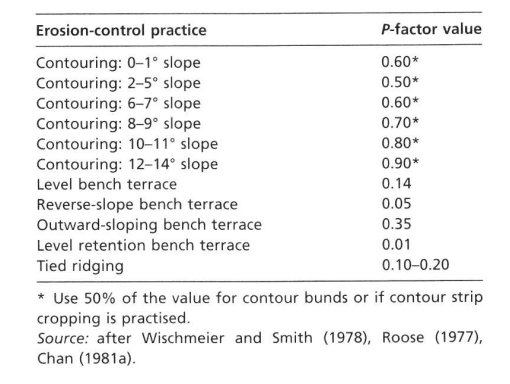

In [46]:
# slope_deg is defined above
# Define function to assign P factor values based on slope_deg
def assign_p_factor(slope_image):
    def get_p_value(slope_deg):
        if slope_deg < 1:
            return 0.60
        elif 1 <= slope_deg <= 5:
            return 0.50
        elif 6 <= slope_deg <= 7:
            return 0.60
        elif 8 <= slope_deg <= 9:
            return 0.70
        elif 10 <= slope_deg <= 11:
            return 0.80
        elif 12 <= slope_deg <= 14:
            return 0.90
        elif 14 <= slope_deg <= 48:
            return 0.14
        else:
            return 1

    # Map function to each pixel in the slope image
    p_factor = slope_image.expression(
        'slope_deg < 1 ? 0.60 : \
        (slope_deg >= 1 && slope_deg <= 5) ? 0.50 : \
        (slope_deg >= 6 && slope_deg <= 7) ? 0.60 : \
        (slope_deg >= 8 && slope_deg <= 9) ? 0.70 : \
        (slope_deg >= 10 && slope_deg <= 11) ? 0.80 : \
        (slope_deg >= 12 && slope_deg <= 14) ? 0.90 : \
        (slope_deg >= 14 && slope_deg <= 48) ? 0.14 : 1',
        {'slope_deg': slope_image}
    ).rename('p_factor').reproject(crs='EPSG:4326', scale=90).clip(geometry)

    return p_factor


In [56]:
# Apply the function to calculate P factor.
p_factor = assign_p_factor(slope)

# Mask the P factor image with the neighborhood to ensure values are confined to the crop neighborhood.
p_factor_masked = p_factor.updateMask(neighborhood)

# Add layers to the map.
p_factor_vis_params = {
  'min': 0,
  'max': 1,
  'palette': ['white', 'black']
}

#Map.addLayer(p_factor_masked, p_factor_vis_params, 'P Factor',0)

randomization (50, 50) between either: the assigned P value above(based on crop clusters and slope and table values)

or assign P = 1 random; to create a mix scenario where practices are applie or not


In [58]:
random_value = ee.Image.random(seed=0).rename('random')
p_factor_randomized = p_factor_masked.where(random_value.lte(0.5), 1).reproject(crs='EPSG:4326', scale=90)

#Map.addLayer(p_factor_randomized, p_factor_vis_params, 'P Factor randomized')



# Compute RUSLE

In [59]:
# reveal the values of both P as assigned above, and all the other (50%) with value 1 by unmasking them:
P_factor = p_factor_randomized.unmask(1)

rusle_P_atRandom = final_erosivity_image.multiply(C90m).multiply(ls90m).multiply(K90m).multiply(P_factor).rename('soil_loss')

P_palette = [
    '568203',  # Very Low - dark green avocado
    '66FF00',  # Low  # light green
    'FFEF00',  # Moderate # yellow canary
    'FF8C00',  # High # orange dark
    '660000' # Very High # blood red
  ]

Map.addLayer(rusle_P_atRandom, {min: 0, max: 100, 'palette': P_palette}, 'Prandom_Soil Loss')

#Here is an asset of the rusle at 90m for sironko district:
#asset = ee.Image("projects/takehome-exam-bugisu-project/assets/RUSLE_sironko90m")
#Map.addLayer(asset, {'min': 0, 'max': 100, 'palette': P_palette}, 'RUSLE')
Map

Map(bottom=260614.0, center=[1.2564605624116145, 34.40437316894532], controls=(WidgetControl(options=['positio…

# Export locally to work on QGIS and make soil loss class_final map (FIGURE 3)

In [ ]:
# Set the export "scale" and "crs" parameters.
task = ee.batch.Export.image.toDrive(
    image=image,
    description='image_export',
    folder='ee_demos',
    region=region,
    scale=90,
    crs='EPSG:4326'  #or the one crs for UTM-zone 36N which is EPSG:32636, better for Uganda
)
#task.start()

# (optional create soil loss classe in here)

In [61]:
# the one used by Bamutaze et al.
SL_class = rusle_P_atRandom.expression(
  "(b('soil_loss') <= 2)? 1" + \
  ": (b('soil_loss') <= 10)? 2" + \
  ": (b('soil_loss') <= 50)? 3" + \
  ": (b('soil_loss') <= 100)? 4" + \
  ": 5") \
.rename('SL_class').reproject(crs = 'EPSG:4326', scale = 90).clip(geometry)

styleSL_class = {
  'min': 1,
  'max': 5,
  'palette':[
    '568203',  # Very Low - dark green avocado
    '66FF00',  # Low  # light green
    'FFEF00',  # Moderate # yellow canary
    'FF8C00',  # High # orange dark
    '660000' # Very High # blood red
  ]
}
Map.addLayer (SL_class, styleSL_class, 'Soil Loss Class')
Map

Map(bottom=260795.0, center=[1.132204750305005, 34.42428588867188], controls=(WidgetControl(options=['position…